### modules

In [15]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

### load dataset

In [16]:
original_df = pd.read_csv("apy.csv")

In [17]:
df = original_df.copy()

In [18]:
df.head()

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
0,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Arecanut,1254.0,2000.0
1,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Other Kharif pulses,2.0,1.0
2,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Rice,102.0,321.0
3,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Banana,176.0,641.0
4,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Cashewnut,720.0,165.0


### more insights about dataset

In [19]:
df.shape

(246091, 7)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246091 entries, 0 to 246090
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   State_Name     246091 non-null  object 
 1   District_Name  246091 non-null  object 
 2   Crop_Year      246091 non-null  int64  
 3   Season         246091 non-null  object 
 4   Crop           246091 non-null  object 
 5   Area           246091 non-null  float64
 6   Production     242361 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 13.1+ MB


In [21]:
df.isna().sum()

State_Name          0
District_Name       0
Crop_Year           0
Season              0
Crop                0
Area                0
Production       3730
dtype: int64

In [22]:
df.dropna(axis=0, inplace=True)

In [23]:
df.shape

(242361, 7)

In [24]:
df.drop_duplicates(inplace=True)
df[df['Area']!=0]
df.shape

(242361, 7)

#### strip all string values

In [25]:
def transform(strVal):
    arr = strVal.split('&')
    return ' and '.join(arr)

for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].str.strip()
        df[col] = df[col].apply(transform)

#### unique counts of categorical features

In [26]:
categorical_features = []
for col in df.columns:
    if df[col].dtype == object or df[col].dtype == np.int64:
        categorical_features.append(col)
unique_cnts = []
for feature in categorical_features:
    unique_cnts.append(len(df[feature].unique()))

    
totals_df = pd.DataFrame(dict({'Categorical Features':categorical_features
                           ,'Unique counts':unique_cnts}))
totals_df

,Categorical Features,Unique counts
0,State_Name,33
1,District_Name,646
2,Crop_Year,19
3,Season,6
4,Crop,124


In [27]:
states = sorted(df['State_Name'].unique().tolist())
districts = sorted(df['District_Name'].unique().tolist())
yrs = sorted(df['Crop_Year'].unique().tolist())
seasons = sorted(df['Season'].unique().tolist())
crops = sorted(df['Crop'].unique().tolist())

In [14]:
# df_bihar = df[df.State_Name=='Bihar'].copy()
# df_bihar.shape

### Label encode categorical feature and store mapping of each feature

In [28]:
lencoder = LabelEncoder()
df['State_Name'] = lencoder.fit_transform(df['State_Name'])
le_State_Name_mapping = dict(zip(lencoder.classes_, map(int,lencoder.transform(lencoder.classes_))))
df['District_Name'] = lencoder.fit_transform(df['District_Name'])
le_District_Name_mapping = dict(zip(lencoder.classes_, map(int,lencoder.transform(lencoder.classes_))))
df['Season'] = lencoder.fit_transform(df['Season'])
le_Season_mapping = dict(zip(lencoder.classes_, map(int,lencoder.transform(lencoder.classes_))))
df['Crop'] = lencoder.fit_transform(df['Crop'])
le_Crop_mapping = dict(zip(lencoder.classes_, map(int,lencoder.transform(lencoder.classes_))))
df['Crop_Year'] = lencoder.fit_transform(df['Crop_Year'])
le_Crop_Year_mapping = dict(zip(map(int,lencoder.classes_), map(int,lencoder.transform(lencoder.classes_))))

In [29]:
le_Crop_mapping

{'Apple': 0,
 'Arcanut (Processed)': 1,
 'Arecanut': 2,
 'Arhar/Tur': 3,
 'Ash Gourd': 4,
 'Atcanut (Raw)': 5,
 'Bajra': 6,
 'Banana': 7,
 'Barley': 8,
 'Bean': 9,
 'Beans  and  Mutter(Vegetable)': 10,
 'Beet Root': 11,
 'Ber': 12,
 'Bhindi': 13,
 'Bitter Gourd': 14,
 'Black pepper': 15,
 'Blackgram': 16,
 'Bottle Gourd': 17,
 'Brinjal': 18,
 'Cabbage': 19,
 'Cardamom': 20,
 'Carrot': 21,
 'Cashewnut': 22,
 'Cashewnut Processed': 23,
 'Cashewnut Raw': 24,
 'Castor seed': 25,
 'Cauliflower': 26,
 'Citrus Fruit': 27,
 'Coconut': 28,
 'Coffee': 29,
 'Colocosia': 30,
 'Cond-spcs other': 31,
 'Coriander': 32,
 'Cotton(lint)': 33,
 'Cowpea(Lobia)': 34,
 'Cucumber': 35,
 'Drum Stick': 36,
 'Dry chillies': 37,
 'Dry ginger': 38,
 'Garlic': 39,
 'Ginger': 40,
 'Gram': 41,
 'Grapes': 42,
 'Groundnut': 43,
 'Guar seed': 44,
 'Horse-gram': 45,
 'Jack Fruit': 46,
 'Jobster': 47,
 'Jowar': 48,
 'Jute': 49,
 'Jute  and  mesta': 50,
 'Kapas': 51,
 'Khesari': 52,
 'Korra': 53,
 'Lab-Lab': 54,
 'Lemon':

In [30]:
le_Season_mapping

{'Autumn': 0,
 'Kharif': 1,
 'Rabi': 2,
 'Summer': 3,
 'Whole Year': 4,
 'Winter': 5}

In [31]:
le_Crop_Year_mapping

{1997: 0,
 1998: 1,
 1999: 2,
 2000: 3,
 2001: 4,
 2002: 5,
 2003: 6,
 2004: 7,
 2005: 8,
 2006: 9,
 2007: 10,
 2008: 11,
 2009: 12,
 2010: 13,
 2011: 14,
 2012: 15,
 2013: 16,
 2014: 17,
 2015: 18}

### save mapping to json file

In [32]:
mapping = {"le_State_Name_mapping":le_State_Name_mapping,
           "le_District_Name_mapping":le_District_Name_mapping,
           "le_Season_mapping":le_Season_mapping,
           "le_Crop_mapping":le_Crop_mapping,
           "le_Crop_Year_mapping":le_Crop_Year_mapping}

In [33]:
json_obj = json.dumps(mapping,indent=4)
with open('encoder_mapping.json', 'w') as outfile:
    outfile.write(json_obj)

In [34]:
df.head()

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
0,0,427,3,1,2,1254.0,2000.0
1,0,427,3,1,74,2.0,1.0
2,0,427,3,1,95,102.0,321.0
3,0,427,3,4,7,176.0,641.0
4,0,427,3,4,22,720.0,165.0


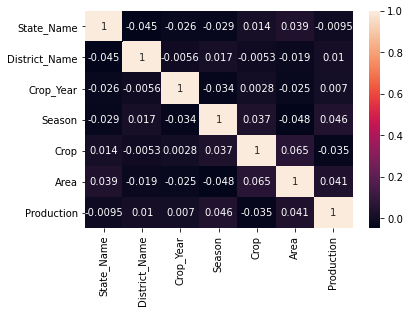

In [35]:
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [36]:
features = df.columns[:-1]
print(features)
X = df[features]
y = df['Production']

Index(['State_Name', 'District_Name', 'Crop_Year', 'Season', 'Crop', 'Area'], dtype='object')


### split and fit data

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [38]:
model = RandomForestRegressor(n_estimators=20, n_jobs=-1, criterion='mse', max_features=2 ,random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2_scr = r2_score(y_test,y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)


print('{:<30} {:>10}'.format('r2_score',r2_scr))
print('{:<30} {:>10}'.format('Mean absolute error',mae))
print('{:<30} {:>10}'.format('Mean squared error',mse))
print('{:<30} {:>10}'.format('Root Mean square error',rmse))

r2_score                       0.9713349919799457
Mean absolute error            85527.9051203144
Mean squared error             6205327456407.957
Root Mean square error         2491049.468880126


In [39]:
model.score(X_test, y_test)

0.9713349919799457

In [40]:
model.score(X_train, y_train)

0.9892664873876678

### saving model with joblib

In [41]:
filename = 'yp_RF_model.sav'
joblib.dump(model, filename)

['yp_RF_model.sav']

In [29]:
# load model from disk
# loaded_model = joblib.load(filename)
# result = loaded_model.score(X_test, Y_test)
# print(result)

### feature importance

In [42]:
feature_imp = model.feature_importances_
labels = X_train.columns.to_list()
df_feature = pd.Series(feature_imp, index=labels).sort_values(ascending=False)
df_feature

Area             0.332566
State_Name       0.203981
Crop             0.198099
District_Name    0.101307
Season           0.099721
Crop_Year        0.064326
dtype: float64

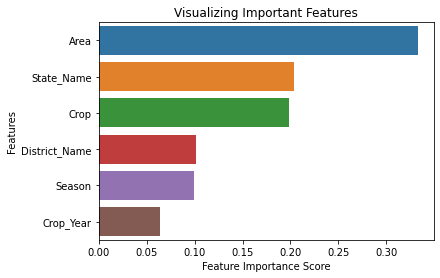

In [43]:
sns.barplot(x = df_feature, y = df_feature.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### permuted importance of features

In [44]:
r = permutation_importance(model, X_test, y_test,
                               n_repeats=15,
                               random_state=1)

In [45]:
for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"{df.columns[i]:<20}"
                  f"{r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")

Area                1.178 +/- 0.043
Crop                0.881 +/- 0.046
State_Name          0.404 +/- 0.071
Season              0.250 +/- 0.025
District_Name       0.153 +/- 0.025
Crop_Year           0.100 +/- 0.039


### Prediction  

In [46]:
print(df.columns[:-1])
state = le_State_Name_mapping['Bihar']
district = le_District_Name_mapping['MUZAFFARPUR']
yr = le_Crop_Year_mapping[2000]
season = le_Season_mapping['Kharif']
crop = le_Crop_mapping['Banana']
area = 80
row = [[state, district, yr, season, crop, area]]
data = pd.DataFrame(data=row, columns=df.columns[:-1].tolist())
data

Index(['State_Name', 'District_Name', 'Crop_Year', 'Season', 'Crop', 'Area'], dtype='object')


,State_Name,District_Name,Crop_Year,Season,Crop,Area
0,4,402,3,1,7,80


In [47]:
model.predict(np.array(row))

array([581.35])

In [48]:
temp = original_df[original_df['State_Name']=='Bihar']
temp = temp[temp['District_Name']=='MUZAFFARPUR']
# temp = temp[temp['Crop_Year']==2000]
# temp = temp[temp['Season']=='Kharif']
temp = temp[temp['Crop']=='Banana']
temp

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
37261,Bihar,MUZAFFARPUR,1997,Whole Year,Banana,744.0,25653.0
37296,Bihar,MUZAFFARPUR,1998,Whole Year,Banana,804.0,16088.0
37333,Bihar,MUZAFFARPUR,1999,Whole Year,Banana,715.0,5527.0
37368,Bihar,MUZAFFARPUR,2000,Whole Year,Banana,753.0,3517.0
37436,Bihar,MUZAFFARPUR,2002,Whole Year,Banana,605.0,5971.0
37473,Bihar,MUZAFFARPUR,2003,Whole Year,Banana,673.0,4011.0
37509,Bihar,MUZAFFARPUR,2004,Whole Year,Banana,553.0,5016.0
37546,Bihar,MUZAFFARPUR,2005,Whole Year,Banana,329.0,2109.0
37602,Bihar,MUZAFFARPUR,2007,Whole Year,Banana,446.0,2997.0


# --------------------------------------------------------------------------Hurray  \\(-_-)/

## deleting least important feature -> 'Crop_Year'
#### and retraining model with remaining features

In [26]:
new_df = df.copy()

In [27]:
new_df.head()

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
0,0,427,3,1,2,1254.0,2000.0
1,0,427,3,1,74,2.0,1.0
2,0,427,3,1,95,102.0,321.0
3,0,427,3,4,7,176.0,641.0
4,0,427,3,4,22,720.0,165.0


In [28]:
new_df.drop(['Crop_Year','District_Name'], axis=1,inplace=True)

In [29]:
features = new_df.columns[:-1]
print(features)
X = new_df[features]
y = new_df['Production']

Index(['State_Name', 'Season', 'Crop', 'Area'], dtype='object')


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [31]:
new_model = RandomForestRegressor(n_estimators=10, n_jobs=-1, criterion='mse', max_features=2 ,random_state=1)
new_model.fit(X_train, y_train)
y_pred = new_model.predict(X_test)

r2_sco = r2_score(y_test,y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)


print('{:<30} {:>10}'.format('r2_score',r2_sco))
print('{:<30} {:>10}'.format('Mean absolute error',mae))
print('{:<30} {:>10}'.format('Mean squared error',mse))
print('{:<30} {:>10}'.format('Root Mean square error',rmse))

r2_score                       0.8635109474361019
Mean absolute error            165510.8207776426
Mean squared error             29546800223510.234
Root Mean square error         5435696.848014083


In [32]:
new_model.score(X_test, y_test)

0.8635109474361019

#### accuracy got decreased even when feature 'Crop_Year' was removed , so all features are important
#### so saving earlier model

In [33]:
print(type(np.array(y_test)))
print(type(y_pred))
aa = np.array(y_test)
bb = y_pred

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [34]:
print('{:<10} {:<10} {:<10} \n'.format('Actual','Predicted','abs diff'))
for i in range(20):
    print('{:<10} {:<10} {:<10}'.format(round(aa[i],1), round(bb[i],1), round(abs(aa[i]-bb[i]),1)))

Actual     Predicted  abs diff   

1959.0     1382.6     576.4     
933.0      1340.8     407.8     
1241.0     941.6      299.4     
18.0       17.9       0.1       
258.0      308.2      50.2      
52.0       55.3       3.3       
6.0        8.3        2.3       
3322.0     3262.7     59.3      
495.0      709.8      214.8     
321.0      580.4      259.4     
6718.0     9822.3     3104.3    
45.0       26.3       18.7      
791.0      517.9      273.1     
892.0      454.5      437.5     
481.0      583.3      102.3     
2030.0     2643.4     613.4     
715.0      568.3      146.7     
15.0       11.4       3.6       
630.0      329.2      300.8     
2219937.0  2574107.1  354170.1  


In [35]:
query = pd.DataFrame()